In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [6]:
from load_data import load_data
df = load_data()

## 1. Implémenter l'analyse RFM

In [7]:
# Calculer la Récence, Fréquence et la valeur Monétaire pour chaque client
df['order_date'] = pd.to_datetime(df['order_date'])

snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)
# Date de référence (lendemain de la dernière commande)

rfm_data = df.groupby('customer_id').agg(
    Recency=('order_date', lambda date: (snapshot_date - date.max()).days),
    Frequency=('order_id', 'count'),
    Monetary=('final_amount', 'sum')
)


C:\Users\Abdel\AppData\Local\Temp\ipykernel_4112\3859635071.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['order_date'] = pd.to_datetime(df['order_date'])


## 2. Créer des segments RFM

In [8]:

# Création de quantiles pour chaque métrique (ex: 4 quantiles, donc score de 1 à 4)
# Pour la Récence, plus la valeur est faible, meilleur est le score.
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=4, labels=r_labels, duplicates='drop').astype(int)
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(int)
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], q=4, labels=m_labels).astype(int)


In [9]:
# Combinaison des scores
rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R_Score']) + str(x['F_Score']) + str(x['M_Score']), axis=1)
rfm_data['RFM_Score'] = rfm_data[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


In [10]:

# Création de segments nommés
def assign_segment_name(row):
    if row['RFM_Score'] >= 11:
        return 'Champions'
    elif row['RFM_Score'] >= 8:
        return 'Clients fidèles'
    elif row['RFM_Score'] >= 6:
        return 'Clients prometteurs'
    elif row['RFM_Score'] >= 4:
        return 'Clients à risque'
    else:
        return 'Clients perdus'

rfm_data['Segment_Name'] = rfm_data.apply(assign_segment_name, axis=1)
print(rfm_data.head())


             Recency  Frequency   Monetary  R_Score  F_Score  M_Score  \
customer_id                                                             
CUST001           26          5  1564.8300        4        3        3   
CUST002           78          5  1515.9740        2        3        3   
CUST003          220          3  1227.9745        1        2        3   
CUST004           10          3   696.2150        4        2        1   
CUST005           14          5  1354.5505        4        3        3   

            RFM_Segment  RFM_Score         Segment_Name  
customer_id                                              
CUST001       4.03.03.0         10      Clients fidèles  
CUST002       2.03.03.0          8      Clients fidèles  
CUST003       1.02.03.0          6  Clients prometteurs  
CUST004       4.02.01.0          7  Clients prometteurs  
CUST005       4.03.03.0         10      Clients fidèles  


## 3. Visualiser les segments

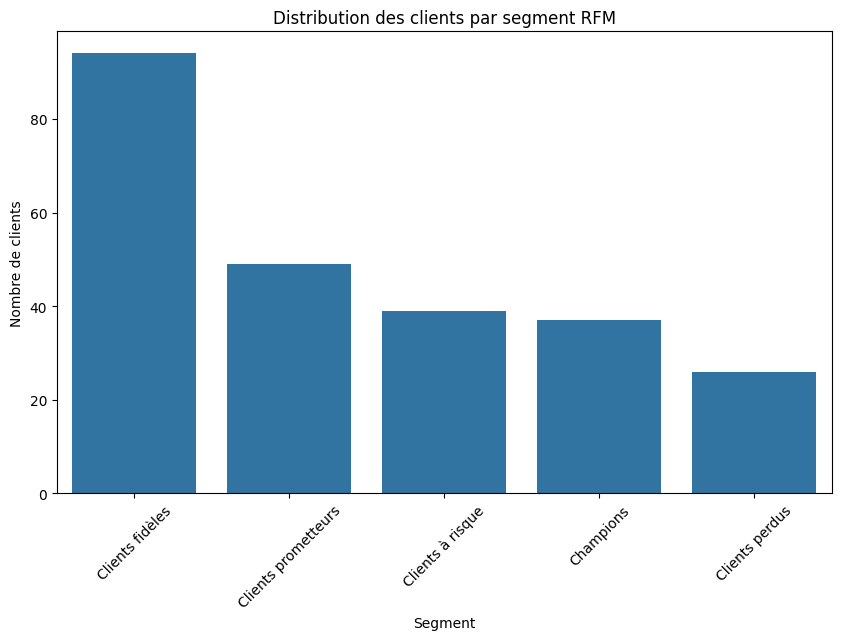

In [11]:

segment_counts = rfm_data['Segment_Name'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Distribution des clients par segment RFM')
plt.xlabel('Segment')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.show()


## 4. Profiler chaque segment

In [12]:
# Fusionner les données RFM avec les données démographiques
customer_demographics = df[['customer_id', 'customer_age', 'customer_region']].drop_duplicates().set_index('customer_id')
rfm_profile = rfm_data.join(customer_demographics)

segment_profile = rfm_profile.groupby('Segment_Name').agg(
    avg_recency=('Recency', 'mean'),
    avg_frequency=('Frequency', 'mean'),
    avg_monetary=('Monetary', 'mean'),
    avg_age=('customer_age', 'mean'),
    customer_count=('Recency', 'count')
)
print("\nProfil des segments :\n", segment_profile)




Profil des segments :
                      avg_recency  avg_frequency  avg_monetary    avg_age  \
Segment_Name                                                               
Champions              23.953846       7.426923   2404.866298  43.276923   
Clients fidèles        66.657837       5.282561   1635.425124  42.863135   
Clients perdus        241.162162       1.594595    380.671000  43.351351   
Clients prometteurs    85.899371       3.503145    987.636500  44.257862   
Clients à risque      147.011628       2.465116    612.823297  42.093023   

                     customer_count  
Segment_Name                         
Champions                       260  
Clients fidèles                 453  
Clients perdus                   37  
Clients prometteurs             159  
Clients à risque                 86  


## 5. Recommander des stratégies marketing
- Champions : Récompenser avec des programmes VIP, des accès anticipés.
- Clients fidèles : Proposer des ventes croisées, des offres de produits à plus forte marge.
- Clients prometteurs : Engager avec des campagnes de réactivation et des offres personnalisées.
- Clients à risque : Lancer des campagnes de reconquête avec des remises attractives.
- Clients perdus : Analyser les raisons de leur départ, considérer des sondages.